In [ ]:
# default_exp flow_neighbor_embedder
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 05d01a Flow Neighbors Loss on the Swiss Roll

We previously demonstrated that the KL Divergence based diffusion matrix loss successfully learned flows on a fixed embedding of the swiss roll. Here, we apply the same test of loss learning to the new "Flow Neighbors" loss described in 05d.

# The Diffusion Map
To begin, we'll initialize a class meant to be slotted in as an "embedder" in our MultiscaleDiffusionFlowEmbedder. When initialized, it will compute and store the diffusion map. When subsequently prompted to embed points, it will return the stored diffusion map, stripped of gradients.

Here is our dataset:

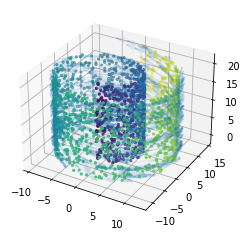

In [ ]:
from directed_graphs.datasets import (
    directed_swiss_roll_sklearn,
    plot_directed_3d,
    affinity_grid_search,
)
X, flow, labels = directed_swiss_roll_sklearn(num_nodes=2000)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

And a diffusion map on the dataset:

/gpfs/loomis/project/krishnaswamy_smita/kjm76/directed_graphs/directed_graphs/utils.py:12: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


using sigma =  2.362789715827196


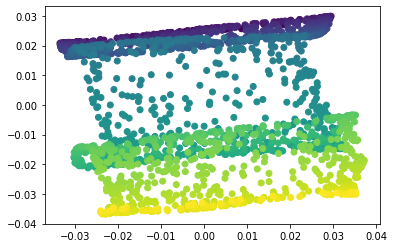

In [ ]:
from directed_graphs.utils import diffusion_map_from_points

diff_map = diffusion_map_from_points(X, kernel_type="anisotropic", k=18, t=1)
plt.scatter(diff_map[:, 0], diff_map[:, 1], c=labels)

In [ ]:
# export
from directed_graphs.diffusion_distance_flow_embedder import FixedDiffusionMapEmbedding
from directed_graphs.multiscale_flow_embedder import MultiscaleDiffusionFlowEmbedder
from directed_graphs.flow_embedding_training_utils import (
    FETrainer,
    visualize_points,
    save_embedding_visualization,
)
from directed_graphs.diffusion_flow_embedding import (
    affinity_matrix_from_pointset_to_pointset,
)
import torch.nn.functional as F
import torch

class FlowEmbedderAroundDiffusionMap(FETrainer):
    def __init__(
        self,
        X,
        flows,
        labels,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        sigma_graph=2.13,
        flow_strength_graph=1,
    ):
        super().__init__(X, flows, labels, device=device)
        self.vizfiz = [
            save_embedding_visualization,
            # visualize_points,
        ]
        loss_weights = {
            "diffusion": 0,
            "smoothness": 0,
            "reconstruction": 0,
            "diffusion map regularization": 0,
            "flow cosine loss": 0,
            "flow neighbor loss": 1,
        }
        P_graph = affinity_matrix_from_pointset_to_pointset(
            X, X, flows, sigma=sigma_graph, flow_strength=0
        )
        P_graph = F.normalize(P_graph, p=1, dim=1)
        self.FE = MultiscaleDiffusionFlowEmbedder(
            X=X,
            flows=flows,
            ts=[1],
            sigma_graph=sigma_graph,
            flow_strength_graph=flow_strength_graph,
            device=device,
            use_embedding_grid=False,
            embedder=FixedDiffusionMapEmbedding(X, t=1, k=18, device=device),
        ).to(device)
        self.title = "Flow Neighbor w Fixed Diffusion Map"
        self.epochs_between_visualization = 1
        self.total_epochs = 1000


And here is our quest to find the right sigma value. Because assymetric kernels violate the *spectral theorem*'s guarantee of real-valued eigenvectors, thethe diffusion map of a directed graph includes complex values. It's unclear whether this remains a good embedding.

To avoid it, we'll set the influence of flow in our kernel to 0. Sigma = 1 gives a good ray of sunshine that doesn't illuminate the spurious folds of the roll.

In [ ]:
# affinity_grid_search(X,flow, sigmas = [0.5, 1, 2.1, 2.13, 2.3, 2.5, 3], flow_strengths = [0,1])


In [ ]:
X = torch.tensor(X).float().to(device)
flow = torch.tensor(flow).float().to(device)
X = X.float().to(device)
flow = flow.float().to(device)


/tmp/ipykernel_228598/3363665456.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).float().to(device)
/tmp/ipykernel_228598/3363665456.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flow = torch.tensor(flow).float().to(device)


## Testing the Diffusion Map

In [ ]:
Flow_around_the_DMAP = FlowEmbedderAroundDiffusionMap(
    X, flow, labels=labels, device=device
)

/gpfs/loomis/project/krishnaswamy_smita/kjm76/directed_graphs/directed_graphs/utils.py:12: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


using sigma =  2.3627894


In [ ]:
Flow_around_the_DMAP.fit()


  1%|          | 12/1000 [00:06<07:28,  2.20it/s]

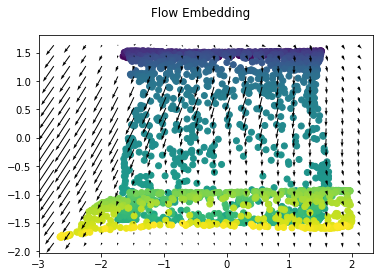

In [ ]:
Flow_around_the_DMAP.visualize_embedding()


In [ ]:
Flow_around_the_DMAP.training_gif(duration=200)


HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYcAAP///////f//+///+v//+P//9f//7f//yv7///z///v///n///…

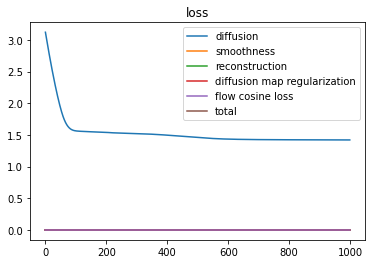

In [ ]:
Flow_around_the_DMAP.visualize_loss()


In [ ]:
Flow_around_the_DMAP.losses["diffusion"]

In [ ]:
import glob
import ipywidgets as widgets
from PIL import Image
import os
import ipywidgets as widgets
import base64

frames = [
    Image.open(image)
    for image in glob.glob(f"visualizations/{BOBO_FET.timestamp}/*.jpg")
]
frame_one = frames[0]
frame_one.save(
    f"{BOBO_FET.title}.gif",
    format="GIF",
    append_images=frames,
    save_all=True,
    duration=300,
    loop=0,
)
# display in jupyter notebook
b64 = base64.b64encode(open(f"{BOBO_FET.title}.gif", "rb").read()).decode("ascii")
display(widgets.HTML(f'<img src="data:image/gif;base64,{b64}" />'))